In [1]:
import os
from pprint import pprint as pp
import pandas as pd
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools
import copy
import seaborn as sns
%matplotlib inline
os.getcwd()

'/home/ryan/Documents/insight_projects/steam_prices/data_analysis'

In [37]:
df = pd.read_pickle('df_steam_db.pkl')

In [36]:
drop_list = ['sale_bool_no_holiday']
for item in drop_list:
    df = df.drop(item,axis =1) #there's probably a more idiomatic way to do this


In [89]:
df.head()

,appid,formatted,fprice,iprice,price_date,sale_bool,formatted_no_holiday,sale_bool_no_holiday,saledates_no_holiday,sale_count,min_iprice,mip_slopes,has_price_slope
0,2430,[],NaN,NaN,NaN,[],[],[],[],0,None,NaN,False
1,297750,"{u'1434047268000': {u'discount': 25, u'initial...","[39.99, 29.99, 39.99, 19.99, 39.99]","[39.99, 39.99, 39.99, 39.99, 39.99]","[1417120656.0, 1434047268.0, 1434994431.0, 144...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1440522322000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1440176720],1,"[39.99, 39.99, 39.99, 39.99, 39.99]",0,False
2,19080,"{u'1434049315000': {u'discount': 75, u'initial...","[9.99, 2.49, 9.99]","[9.99, 9.99, 9.99]","[1417120656.0, 1434049315.0, 1434996542.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1434996542000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],0,"[9.99, 9.99, 9.99]",0,False
3,278850,"{u'1417513376000': {u'discount': 50, u'initial...","[4.99, 2.49, 4.99, 2.49, 4.99, 1.49, 4.99]","[4.99, 4.99, 4.99, 4.99, 4.99, 4.99, 4.99]","[1417120656.0, 1417513376.0, 1417545207.0, 141...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1417545207000': {u'discount': 0, u'initial'...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1417513376],1,"[4.99, 4.99, 4.99, 4.99, 4.99, 4.99, 4.99]",0,False
4,367260,"{u'1435856718000': {u'discount': 0, u'initial'...","[5.39, 5.99, 4.01, 5.99, 6.29, 6.99, 5.24, 6.99]","[5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99]","[1430513702.0, 1431104712.0, 1434045990.0, 143...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","{u'1430513702000': {u'discount': 10, u'initial...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1435268707, 1441127115, 1430513702]",3,"[5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99]",0,False


<h4>make time between sales

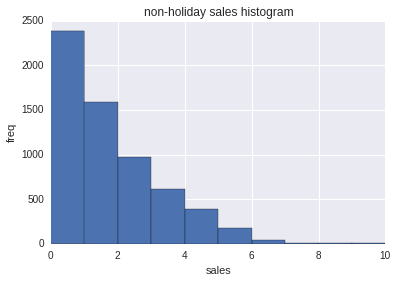

In [38]:
df['sale_count'] = df.saledates_no_holiday.map(len)
df.sale_count.plot(kind='hist',bins = np.array([0,1,2,3,4,5,6,7,8,9,10]))
plt.title('non-holiday sales histogram')
plt.ylabel('freq')
plt.xlabel('sales')

In [ ]:
Get initial price slope

In [83]:
def make_descend(np_array):
    if np_array != None and not np.sum(np.isnan(np_array))>0:
        new = np_array
        cur_min = np.infty
        for i,idum in np.ndenumerate(np_array):
            new[i] = np.min([cur_min,np_array[i]])
            cur_min = new[i]
    else:
        new = None
    return new


min_iprice = list()
for item in df.iprice:
    min_iprice_descent = make_descend(item)
    min_iprice.append(min_iprice_descent)
df['min_iprice'] = min_iprice

slopes = list()
month_second = 60*60*24 * 30
for x,y in zip(df['price_date'],df['min_iprice']):
    if abs(np.sum(x)) >0: 
        linstat = stats.linregress(x / month_second,np.ceil(y))
    else:
        linstat = (np.nan,np.nan)
    cur_slope = linstat[0]
    in_slope = np.max([cur_slope,-30])
    slopes = np.append(slopes,in_slope)

df['mip_slopes'] = slopes
df['has_price_slope'] =df.mip_slopes < -0.1

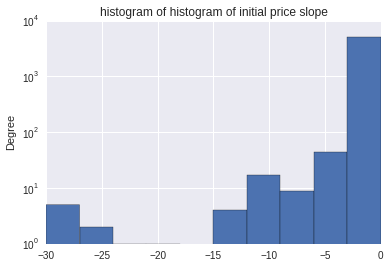

In [84]:
df['mip_slopes'].plot(kind ='hist')
plt.yscale('log')
plt.title('histogram of histogram of initial price slope')

<h4>Make ISI. If something seems off, CHECK THIS FIRST

In [95]:
def make_dirty_isi(sale_list):
    '''
    this function creates inter-sale intervals.
    It is "dity" as it doesn't respect the release dates of the products
    sale_list is a list of consecutive unix timestamps
    the "first_dif" and "final_dif" just use the bounds of the time stamp, this probably introduces
    artifacts that will need to be corrected, but it'll work for initial prototyping for now
    '''
    min_timestamp = 1417120656 #these numbers are drawn from the min and max values seen in the lists
    max_timestamp = 1442077561
    sale_list_process = [min_timestamp] + sale_list + [max_timestamp]
    sale_list_process = sorted(sale_list_process)
    time_since = list()
    if len(sale_list) > 0:
        #time_since.append(min_timestamp)
        #first_dif = sale_list[0] - min_timestamp
        time_since.append(first_dif)
        for i,item in enumerate(sale_list_process[1:]):
            dif = item - sale_list[i-1]
            time_since.append(dif)
    return time_since

In [124]:
sale_list = df.saledates_no_holiday[14]
min_timestamp = 1417120656 #these numbers are drawn from the min and max values seen in the lists
max_timestamp = 1442077561
sale_list_process = [min_timestamp] + sale_list + [max_timestamp]
sale_list_process = sorted(sale_list_process)
time_since = list()

time_since = np.array(sale_list_process[1:]) - np.array(sale_list_process[0:-1])

# if len(sale_list) > 0:
#     #time_since.append(min_timestamp)
#     #first_dif = sale_list[0] - min_timestamp
#     time_since.append(first_dif)


[1417120656, 1422295525, 1428339924, 1439831102, 1442077561]
[ 5174869  6044399 11491178  2246459]


In [121]:
1422295525 - 1417120656

5174869

In [111]:
df['dirty_isi'] = df.saledates_no_holiday.map(make_dirty_isi)

In [112]:
df['dirty_isi']

0                                            [24956905]
1                       [1417120656, 23056064, 1900841]
2                                            [24956905]
3                        [1417120656, 392720, 24564185]
4     [1417120656, 18148051, 10613413, -4755005, 115...
5                       [1417120656, 6384532, 18572373]
6                       [1417120656, 8800175, 16156730]
7                       [1417120656, 20550487, 4406418]
8                                            [24956905]
9                                            [24956905]
10                   [1417120656, 20896105, 0, 9913859]
11                                           [24956905]
12                                           [24956905]
13                                           [24956905]
14    [1417120656, 22710446, -6044399, -11491178, 13...
...
6183    [1417120656, 854848, -11487602, 21596420, 1148...
6184     [1417120656, 4051658, 4741816, 265789, 20639458]
6185    [1417120656, 14243335, -5439631,